# Trabalho Final

### Projete e treine uma rede neural para efetuar um cálculo (soma, subtração, ou multiplicação) usando duas imagens do MNIST. 

Exemplos: 
* (Imagem do dígito 3) + (Imagem do dígito 5) = 8
* (Imagem do dígito 2) - (Imagem do dígito 1) = 1
* (Imagem do dígito 9) x (Imagem do dígito 5) = 45
* (Imagem do dígito 1) + (Imagem do dígito 2) = 3

Dicas: 
* A rede receberá duas entradas: um tensor contento duas imagens, e outro tensor contendo um inteiro que representa a operação
* A saída sempre será um número inteiro 
* Os índices das operações são os seguintes: 0 - Soma, 1 - Subtração, 2 - Multiplicação
* Pense em uma forma de transformar os inteiros que representam as operações em vetores

In [1]:
%matplotlib inline

### Atenção: Rode esta linha apenas se estiver usando o Google Colab

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
import torch
from torch import nn
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

### O código das célula abaixo contém funções para efetuar a carga dos dados, treinamento e teste dos modelos

In [3]:
def train(
        model,
        train_loader,
        test_loader,
        device,
        lr,
        nb_epochs=3,
        log_interval=100,
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    print('\n* * * Evaluating * * *')
    acc = test(model, device, criterion, test_loader)
    
    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)
    
    return acc



In [4]:
def get_loaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=True, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=False, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    return train_loader, test_loader



In [5]:
from collections import OrderedDict
operators = OrderedDict({
    '': -1,
    '+': 0,
    '-': 1,
    '*': 2,
})

n_operators = len(operators)-1
operators_i2o = {v: k for k, v in operators.items()}

In [6]:
def collate_fn(data):
    digits, labels = zip(*data)
    digits = torch.stack(digits, 0).float()
    labels = torch.stack(labels, 0)
    
    digits_idxs_mask = sample_digits(digits, 2)
    
    new_data = digits[digits_idxs_mask]
    digit_targets = labels[digits_idxs_mask]
    
    sampled_ops = sample_operators(len(new_data), 1, total_ops=3)
    target, equation_str = make_ground_truth(digit_targets, sampled_ops)

    return new_data, target, equation_str, sampled_ops

In [7]:
def sample_digits(data, n_digits):
    N = data.shape[0]
    clear_diag = (1-torch.eye(N, N))
    prob_matrix = clear_diag * torch.empty(N, N).uniform_(0, 1)
    return torch.multinomial(prob_matrix, n_digits)

In [8]:
def sample_operators(n_samples, sample_n_ops, total_ops=3):
    return torch.multinomial(torch.empty(n_samples, total_ops).uniform_(0, 1), sample_n_ops)

In [9]:
def make_ground_truth(digit_targets, sampled_ops):
    
    result_targets = []
    result_equations = []
    
    for ds, op in zip(digit_targets, sampled_ops):
        op = torch.cat([op, -torch.ones(1).long()])
        
        equation = ''.join(['{}{}'.format(d, operators_i2o[o.item()]) for d, o in zip(ds, op)])
        result_equations.append(equation)
        result = eval(equation)
        result_targets.append(result)
    
    return torch.LongTensor(result_targets)+9, result_equations
    

In [10]:
def plot_instances(new_data, operators, pred_scores, nb_inst=5):
    fig, axes = plt.subplots(nb_inst, 2, )
    for i in range(nb_inst):
        axs = axes[i]
        data = new_data[i]
        ops = operators[i]
        pred = pred_scores[i]
        for digit, ax in zip(data, axs):
            digit = digit.cpu().permute(1, 2, 0).squeeze()        
            ax.imshow(digit, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        ax.text(-50, 15, operators_i2o[ops[0].item()], fontsize=24)
        ax.text(30, 15, '={}'.format(pred.cpu().numpy()-9), fontsize=24)    
    

In [11]:
def train_epoch(
        model, 
        device, 
        train_loader, 
        optimizer, 
        criterion, 
        epoch, 
        log_interval
    ):
    model.train()
    history = []
    for batch_idx, data in enumerate(train_loader):
        data, target, eq_str, sampled_ops = data
        data = data.to(device)
        target = target.to(device)
        sampled_ops= sampled_ops.to(device)
        
        optimizer.zero_grad()
        output = model(digits=data, ops=sampled_ops)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



In [12]:
def test(
        model, 
        device, 
        criterion, 
        test_loader, 
        plot_images=True
    ):
    model.eval()
    test_loss = 0
    correct = 0
    mse_loss = nn.MSELoss()
    total_mse = 0
    with torch.no_grad():
        for data, target, eq_str, sampled_ops in test_loader:
    
            data = data.to(device)
            target = target.to(device)
            sampled_ops= sampled_ops.to(device)
            
            output = model(digits=data, ops=sampled_ops)
            test_loss += criterion(output, target).item() # sum up batch loss                        
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            
            total_mse += mse_loss(pred.float().squeeze(), target.float()).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        plot_instances(new_data=data, operators=sampled_ops, pred_scores=pred)            
            
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set:\nAverage loss: {:.4f}\nAccuracy: {}/{} ({:.2f}%)\nErro Médio: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy, total_mse))
    return accuracy

### Hyper-parâmetros que você pode definir

In [13]:
batch_size = 16
device_name = 'cpu'
nb_epochs = 10
log_interval = 50
lr = 1e-3

In [14]:
device = torch.device(device_name)

### Conferência dos dados

#### Entrada da rede: digits=(batch, num_digitos, canais, altura, largura), ops=(batch, operador) 
* num_digitos=2
* canais=1
* altura
* largura=28

### Operadores 
* -1) Nenhum
* 0) Soma (`+`)
* 1) Subtração (`-`)
* 2) Multiplicação (`*`)

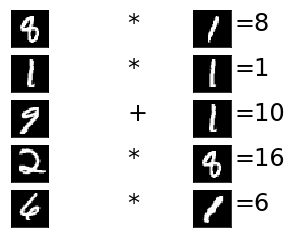

In [15]:
train_loader, test_loader = get_loaders(batch_size=batch_size)
digit_images, eq_target, eq_str, operator_ids = next(iter(train_loader))

plot_instances(digit_images, operator_ids, eq_target)

In [16]:
print('Dados de entrada na rede:')
print('Imagens   : ', digit_images.shape)
print('Operadores: ', operator_ids.shape)
print('... Ex Ops: ', operator_ids[:5].numpy().tolist(), operators)
print('Classes   : ', eq_target.shape)
print('... Ex Cls: ', eq_target[:5].numpy().tolist())

Dados de entrada na rede:
Imagens   :  torch.Size([16, 2, 1, 28, 28])
Operadores:  torch.Size([16, 1])
... Ex Ops:  [[2], [2], [0], [2], [2]] OrderedDict([('', -1), ('+', 0), ('-', 1), ('*', 2)])
Classes   :  torch.Size([16])
... Ex Cls:  [17, 10, 19, 25, 15]


## Seu trabalho começa aqui

### 1) Implemente uma rede capaz de compreender o conteúdo das imagens do MNIST.

In [20]:
class DigitsConvNet(nn.Module):
    def __init__(self):
        super(DigitsConvNet, self).__init__()
        self.conv_a = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv_b = nn.Conv2d(32, 64, 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_a(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv_b(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        return x

In [21]:
net = DigitsConvNet()
pred = net(torch.zeros(5, 1, 28, 28))

assert pred.shape[0] == 5 and len(pred.shape) == 2
print('Passed! Go to the next step.')

Passed! Go to the next step.


### 2) Implemente uma rede neural capaz de resolver uma operação matemática entre duas imagens do MNIST. 
* **DICA**: Utilize a DigitsConvNet como um módulo dentro da EquationNet para extrair vetores de características de todas as imagens.

In [101]:
class EquationNet(nn.Module):
    def __init__(self):
        super(EquationNet, self).__init__()
        self.digitsConvNet = DigitsConvNet()
        self.embedding = nn.Embedding(num_embeddings = 3, embedding_dim = 3136)
        self.lc = nn.Linear(64, 91)
        self.conv_1 = nn.Conv1d(3136, 128, 2)
        self.conv_2 = nn.Conv1d(128, 64, 2)
        self.relu = nn.ReLU()
        
    def forward(self, digits, ops):
        '''
        Arguments:
            digits (FloatTensor): cada linha contém duas imagens do MNIST. 
                                  Shape esperado: (batch, 2, 1, 28, 28)
            ops (LongTensor): cada linha contém uma operação representada em formato de números inteiros (batch, 1).
                              Shape esperado: (batch, 1)  
        Return: 
            result (FloatTensor): cada linha [i] contém o resultado da operação ops[i] 
                    aplicada entre as duas imagens digits[i]. 
                    Note que a resposta deve ser discreta, isto é, representada através de um neurônio. 
                    Shape esperado: (batch, 91)
        '''
        
        features_1 = self.digitsConvNet(digits[:, 0, :, :, :])
        features_2 = self.digitsConvNet(digits[:, 1, :, :, :])
        features_ops = self.embedding(ops)
        features_ops = features_ops.view(features_ops.shape[0], -1)
        
        features = torch.stack((features_1, features_2, features_ops), dim = 2)
    
        features = self.conv_1(features)
        features = self.relu(features)
        features = self.conv_2(features)
        features = self.relu(features)
        
        features = features.view(features.shape[0], -1)
        
        result = self.lc(features)
        return result

In [102]:
model = EquationNet().to(device)

# Init dummy data
dummy_digits = torch.zeros(5, 2, 1, 28, 28).to(device)
dummy_operators = torch.zeros(5, 1).long().to(device)
# Forward 
dummy_pred = model(digits=dummy_digits, ops=dummy_operators)

In [103]:
# Check network's input and output
assert dummy_pred.shape == (5, 91), 'Expected: (5, 10), Found: {}'.format(dummy_pred.shape)
print('Passed')

Passed


### 3) Treine seu modelo por algumas épocas e reporte o resultado. 
* **Dica**: com uma rede leve, em 4 épocas, é possível alcançar acurácia de >=95%, e um erro médio <=1500. 


* * * Evaluating * * *
Test set:
Average loss: 0.2825
Accuracy: 272/10000 (2.72%)
Erro Médio: 1689832.56


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.491412
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.860200
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.916043
Train Epoch: 1 [2400/60000 (4%)]	Loss: 3.438873
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.303668
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.547476
Train Epoch: 1 [4800/60000 (8%)]	Loss: 3.283801
Train Epoch: 1 [5600/60000 (9%)]	Loss: 2.887779
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.678401
Train Epoch: 1 [7200/60000 (12%)]	Loss: 2.592456
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.874113
Train Epoch: 1 [8800/60000 (15%)]	Loss: 2.326267
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.331568
Train Epoch: 1 [10400/60000 (17%)]	Loss: 1.992593
Train Epoch: 1 [11200/60000 (19%)]	Loss: 1.846882
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.908506
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.339521
Train Epoch: 1 [13600/60000 (23%)]	Loss: 1.871

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.362731
Train Epoch: 3 [7200/60000 (12%)]	Loss: 0.223835
Train Epoch: 3 [8000/60000 (13%)]	Loss: 0.140564
Train Epoch: 3 [8800/60000 (15%)]	Loss: 0.087298
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.212031
Train Epoch: 3 [10400/60000 (17%)]	Loss: 0.030095
Train Epoch: 3 [11200/60000 (19%)]	Loss: 0.008879
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.663965
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.234626
Train Epoch: 3 [13600/60000 (23%)]	Loss: 0.201655
Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.019404
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.925669
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.246880
Train Epoch: 3 [16800/60000 (28%)]	Loss: 0.021417
Train Epoch: 3 [17600/60000 (29%)]	Loss: 0.010180
Train Epoch: 3 [18400/60000 (31%)]	Loss: 0.030165
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.075038
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.769479
Train Epoch: 3 [20800/60000 (35%)]	Loss: 0.028061
Train Epoch: 3 [21600/60000 (36%)]	Loss: 0.230630
Train

Train Epoch: 5 [14400/60000 (24%)]	Loss: 0.007173
Train Epoch: 5 [15200/60000 (25%)]	Loss: 0.001072
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.101188
Train Epoch: 5 [16800/60000 (28%)]	Loss: 0.020987
Train Epoch: 5 [17600/60000 (29%)]	Loss: 0.011957
Train Epoch: 5 [18400/60000 (31%)]	Loss: 0.452873
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002192
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.002501
Train Epoch: 5 [20800/60000 (35%)]	Loss: 0.306877
Train Epoch: 5 [21600/60000 (36%)]	Loss: 0.084444
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.091522
Train Epoch: 5 [23200/60000 (39%)]	Loss: 0.128579
Train Epoch: 5 [24000/60000 (40%)]	Loss: 0.005191
Train Epoch: 5 [24800/60000 (41%)]	Loss: 0.006034
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.126584
Train Epoch: 5 [26400/60000 (44%)]	Loss: 0.004929
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.312021
Train Epoch: 5 [28000/60000 (47%)]	Loss: 0.001923
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.006818
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.003449


Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.007873
Train Epoch: 7 [23200/60000 (39%)]	Loss: 0.000967
Train Epoch: 7 [24000/60000 (40%)]	Loss: 0.007926
Train Epoch: 7 [24800/60000 (41%)]	Loss: 0.047707
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.001405
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.027905
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.027125
Train Epoch: 7 [28000/60000 (47%)]	Loss: 0.012365
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.007717
Train Epoch: 7 [29600/60000 (49%)]	Loss: 0.378955
Train Epoch: 7 [30400/60000 (51%)]	Loss: 0.000567
Train Epoch: 7 [31200/60000 (52%)]	Loss: 0.004883
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000477
Train Epoch: 7 [32800/60000 (55%)]	Loss: 0.366119
Train Epoch: 7 [33600/60000 (56%)]	Loss: 0.349952
Train Epoch: 7 [34400/60000 (57%)]	Loss: 0.015494
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.022915
Train Epoch: 7 [36000/60000 (60%)]	Loss: 0.172044
Train Epoch: 7 [36800/60000 (61%)]	Loss: 0.008227
Train Epoch: 7 [37600/60000 (63%)]	Loss: 0.025998


Train Epoch: 9 [30400/60000 (51%)]	Loss: 0.018140
Train Epoch: 9 [31200/60000 (52%)]	Loss: 0.102181
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.407674
Train Epoch: 9 [32800/60000 (55%)]	Loss: 0.280737
Train Epoch: 9 [33600/60000 (56%)]	Loss: 0.000832
Train Epoch: 9 [34400/60000 (57%)]	Loss: 0.066981
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.345550
Train Epoch: 9 [36000/60000 (60%)]	Loss: 0.001378
Train Epoch: 9 [36800/60000 (61%)]	Loss: 0.007644
Train Epoch: 9 [37600/60000 (63%)]	Loss: 0.000862
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.001797
Train Epoch: 9 [39200/60000 (65%)]	Loss: 0.123282
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000666
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.044638
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.084677
Train Epoch: 9 [42400/60000 (71%)]	Loss: 0.377199
Train Epoch: 9 [43200/60000 (72%)]	Loss: 0.000786
Train Epoch: 9 [44000/60000 (73%)]	Loss: 0.000337
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000498
Train Epoch: 9 [45600/60000 (76%)]	Loss: 0.000331


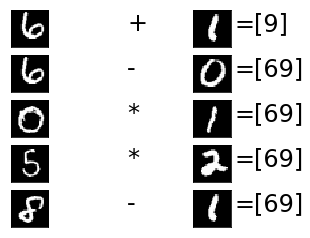

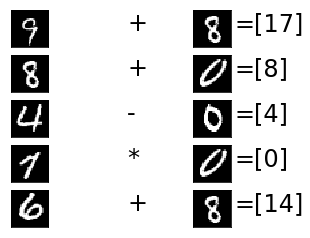

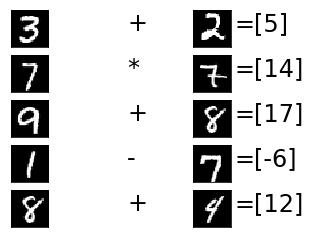

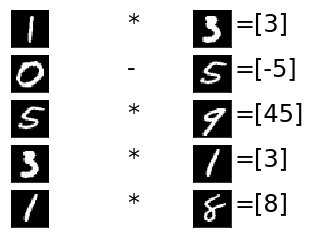

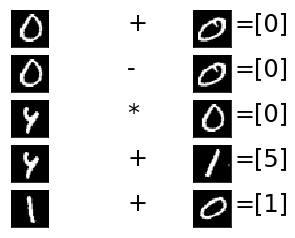

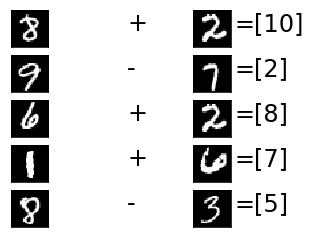

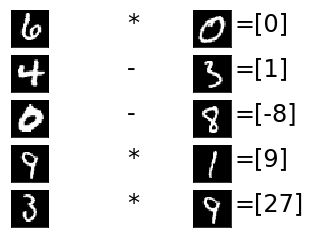

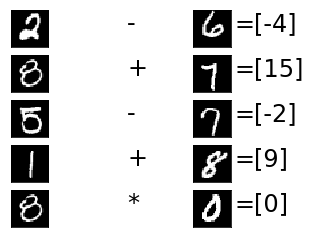

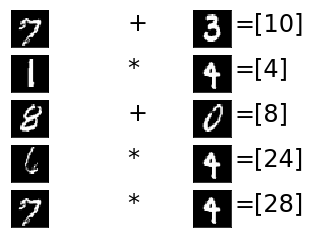

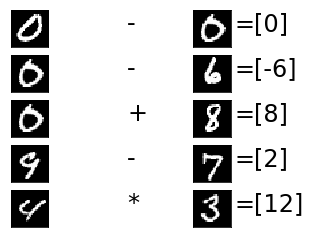

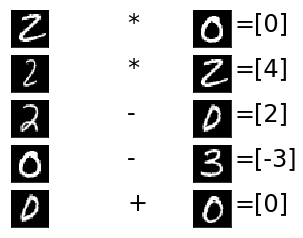

In [104]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))